# Select isobaths to use for ASC and heat transport calculation

Map of barotropic velocity (annual mean) and isobaths to select appropriate depth levels.

In [1]:
# Standard modules
from pathlib import Path
import cosima_cookbook as cc
from dask.distributed import Client
import numpy as np
import xarray as xr

import xgcm
import cf_xarray

# Load metpy module to obtain cross section 
# (Select the conda/analysis3-unstable kernel if you have problems loading this module)
# from metpy.interpolate import cross_section

# For plotting
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cmocean as cm
import pyproj

In [2]:
client = Client() # n_workers=4
client

<Client: 'tcp://127.0.0.1:36061' processes=7 threads=7, memory=32.00 GiB>

In [3]:
session = cc.database.create_session()
experiment = '01deg_jra55v13_ryf9091'

In [4]:
lat_slice  = slice(-80, -59)

start_time = '2086-01-01'
end_time   = '2086-12-31'

Bathymetry

In [5]:
hu = cc.querying.getvar(experiment, 'hu', session, n=1).sel(yu_ocean=lat_slice).load()  # .drop(['geolat_c', 'geolon_c'])

In [6]:
u = cc.querying.getvar(experiment, 'u', session, ncfile="ocean.nc",
                       start_time=start_time, end_time=end_time).sel(yu_ocean=lat_slice).mean('time')

v = cc.querying.getvar(experiment, 'v', session, ncfile="ocean.nc",
                       start_time=start_time, end_time=end_time).sel(yu_ocean=lat_slice).mean('time')


Vertical average

In [7]:
# Import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(experiment, 'st_edges_ocean', session, start_time=start_time, end_time=end_time, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yu_ocean': u.yu_ocean, 'xu_ocean': u.xu_ocean}, axis=[1, 2])

In [8]:
# Adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<hu, other=hu)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# Change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(experiment, 'st_ocean', session, n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean': 'st_ocean'}))
thickness = thickness.sel(st_ocean=slice(0, 500))

# Depth average gives us the barotropic velocity
u_bt = (u * thickness).sum('st_ocean') / thickness.sum('st_ocean')
v_bt = (v * thickness).sum('st_ocean') / thickness.sum('st_ocean')

In [9]:
# Speed
speed = np.sqrt(u_bt**2 + v_bt**2).load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
 

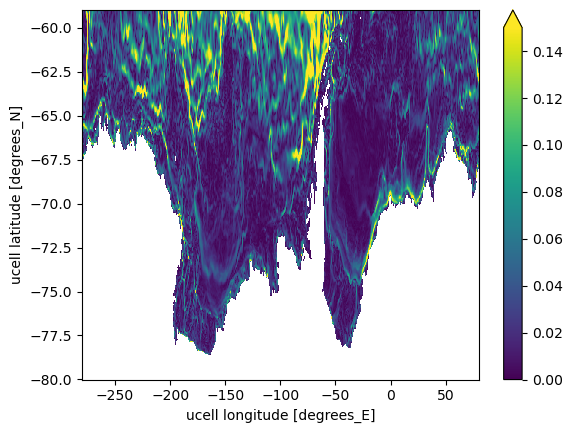

In [29]:
speed.plot(vmin=0, vmax=0.15)

Plotting

In [10]:
theta  = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.45
verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [11]:
land = xr.where(np.isnan(hu.rename('land')), 1, np.nan)

In [12]:
ft_size = 16
plt.rcParams.update({'font.size': ft_size})

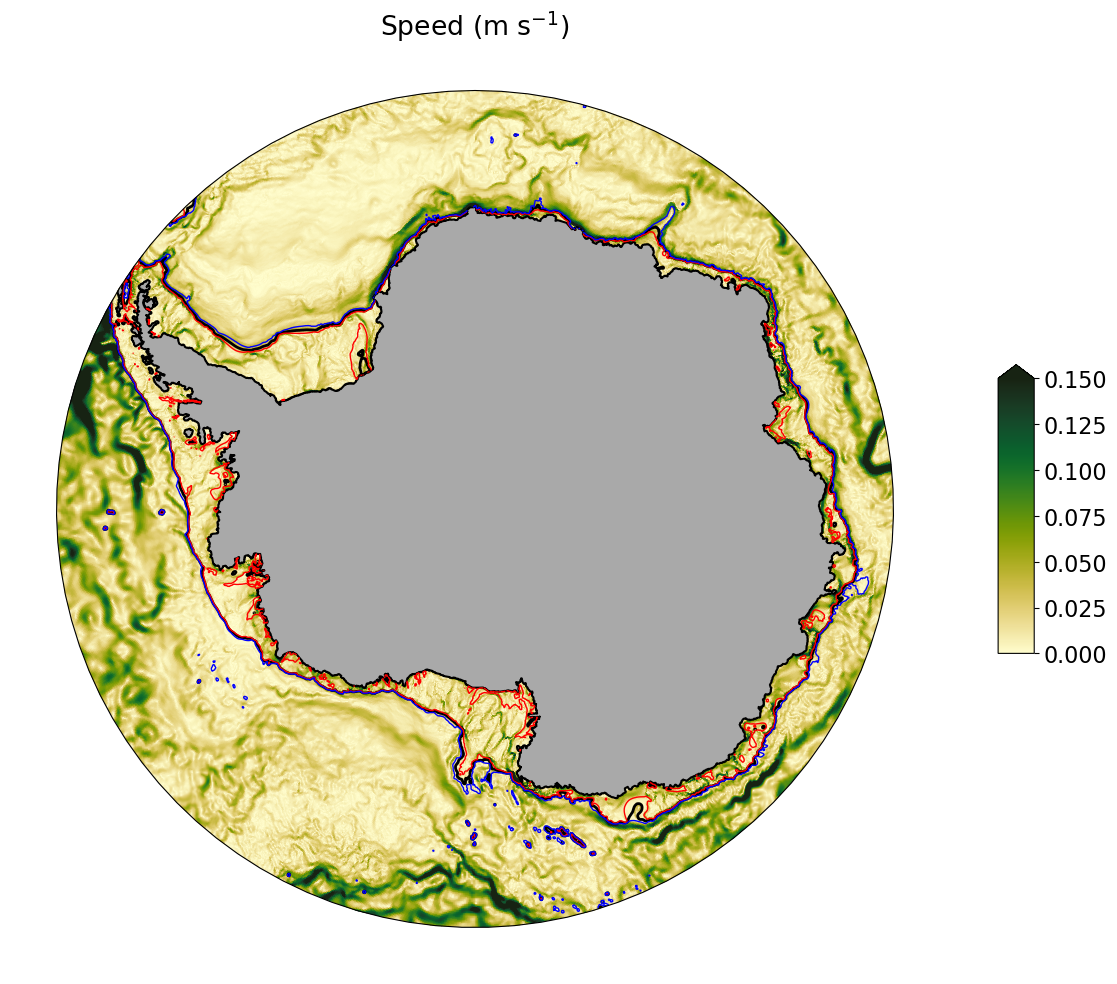

In [13]:
fig = plt.figure(1, figsize=(15, 15))

ax = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo(), facecolor="darkgrey")
ax.set_boundary(circle, transform=ax.transAxes)
    
# Filled land 
land.plot.contourf(ax=ax, colors='darkgrey', zorder=2,
                   transform=ccrs.PlateCarree(), add_colorbar=False)

# Coastline
land.fillna(0).plot.contour(ax=ax, colors='k', levels=[0, 1],
                            transform=ccrs.PlateCarree(), add_colorbar=False)

# Depth contours
hu.plot.contour(ax=ax, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())
hu.plot.contour(ax=ax, levels=[650], colors='r', linewidths=1, transform=ccrs.PlateCarree())
hu.plot.contour(ax=ax, levels=[1500], colors='b', linewidths=1, transform=ccrs.PlateCarree())
# hu.plot.contour(ax=ax, levels=[2000], colors='w', linewidths=1, transform=ccrs.PlateCarree())
# hu.plot.contour(ax=ax, levels=[2500], colors='k', linewidths=1, transform=ccrs.PlateCarree())

# Along slope barotropic velocity
sc = speed.plot(ax=ax, cmap=cm.cm.speed,
                       transform=ccrs.PlateCarree(), vmin=0, vmax=0.15,
                       cbar_kwargs={'orientation': 'vertical',
                                    'shrink': 0.25,
                                    'extend': 'max',
                                    'label': None,
                                    'aspect': 8})

ax.set_title('Speed (m s$^{-1}$)');

# plt.savefig('/g/data/x77/wgh581/Figures/Figures_ASC_and_HeatTransport/Fig_speed_bathymetry_contours.png')

Sectors

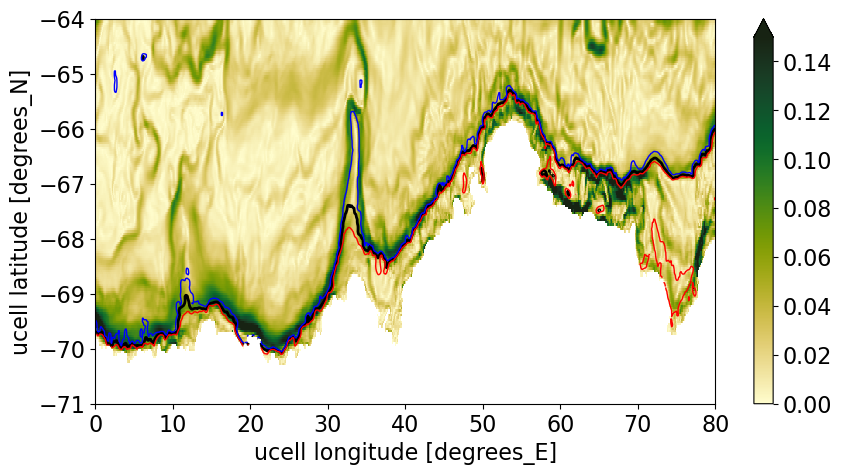

In [14]:
fig = plt.figure(figsize=(10,5))
speed.plot(cmap=cm.cm.speed, vmin=0, vmax=0.15)

# Depth contours
hu.plot.contour(levels=[1000], colors='k', linewidths=2)
hu.plot.contour(levels=[650], colors='r', linewidths=1)
hu.plot.contour(levels=[1500], colors='b', linewidths=1)
# hu.plot.contour(levels=[2000], colors='w', linewidths=1)
# hu.plot.contour(levels=[2500], colors='k', linewidths=1)

plt.xlim(0, 80)
plt.ylim(-71, -64);

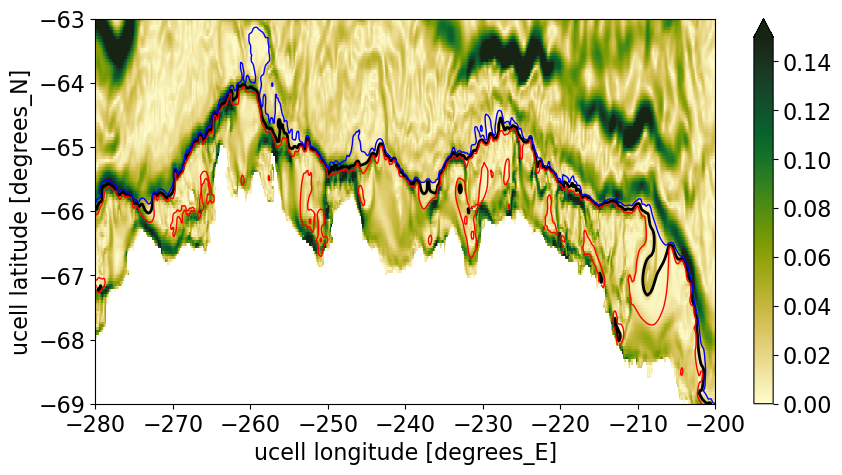

In [15]:
fig = plt.figure(figsize=(10,5))
speed.plot(cmap=cm.cm.speed, vmin=0, vmax=0.15)

# Depth contours
hu.plot.contour(levels=[1000], colors='k', linewidths=2)
hu.plot.contour(levels=[650], colors='r', linewidths=1)
hu.plot.contour(levels=[1500], colors='b', linewidths=1)
# hu.plot.contour(levels=[2000], colors='w', linewidths=1)
# hu.plot.contour(levels=[2500], colors='k', linewidths=1)

plt.xlim(-280,-200)
plt.ylim(-69, -63);

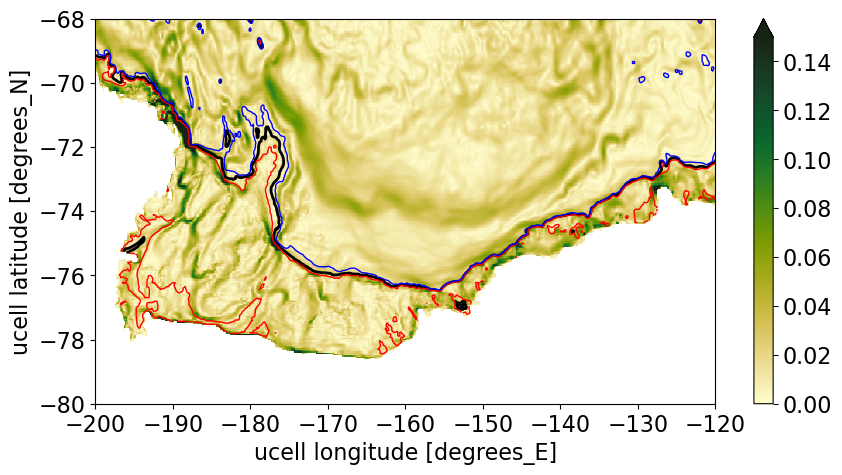

In [16]:
fig = plt.figure(figsize=(10,5))
speed.plot(cmap=cm.cm.speed, vmin=0, vmax=0.15)

# Depth contours
hu.plot.contour(levels=[1000], colors='k', linewidths=2)
hu.plot.contour(levels=[650], colors='r', linewidths=1)
hu.plot.contour(levels=[1500], colors='b', linewidths=1)
# hu.plot.contour(levels=[2000], colors='w', linewidths=1)
# hu.plot.contour(levels=[2500], colors='k', linewidths=1)

plt.xlim(-200,-120)
plt.ylim(-80, -68);

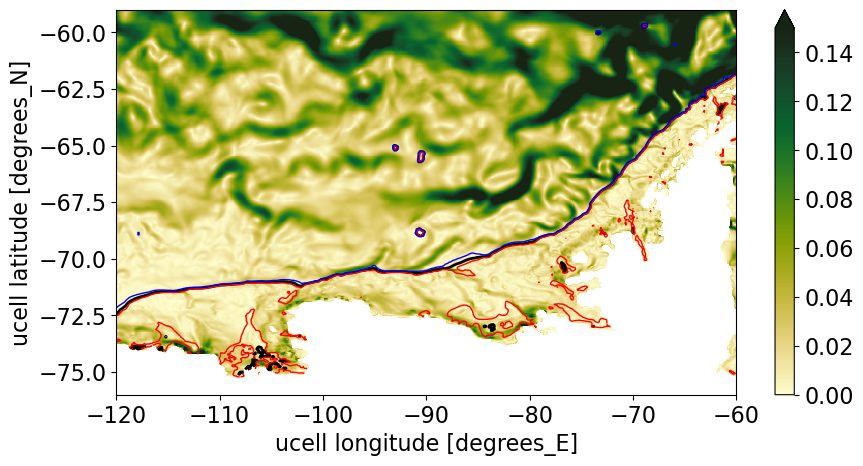

In [17]:
fig = plt.figure(figsize=(10,5))
speed.plot(cmap=cm.cm.speed, vmin=0, vmax=0.15)

# Depth contours
hu.plot.contour(levels=[1000], colors='k', linewidths=2)
hu.plot.contour(levels=[650], colors='r', linewidths=1)
hu.plot.contour(levels=[1500], colors='b', linewidths=1)
# hu.plot.contour(levels=[2000], colors='w', linewidths=1)
# hu.plot.contour(levels=[2500], colors='k', linewidths=1)

plt.xlim(-120,-60)
plt.ylim(-76, -59);

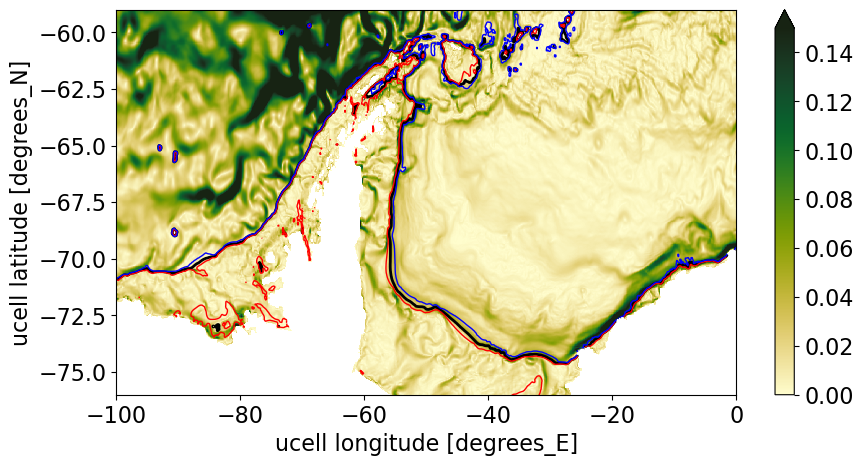

In [18]:
fig = plt.figure(figsize=(10,5))
speed.plot(cmap=cm.cm.speed, vmin=0, vmax=0.15)

# Depth contours
hu.plot.contour(levels=[1000], colors='k', linewidths=2)
hu.plot.contour(levels=[650], colors='r', linewidths=1)
hu.plot.contour(levels=[1500], colors='b', linewidths=1)
# hu.plot.contour(levels=[2000], colors='w', linewidths=1)
# hu.plot.contour(levels=[2500], colors='k', linewidths=1)

plt.xlim(-100,0)
plt.ylim(-76, -59);

## Location of isobath-contours from Adele's code

In [7]:
lat_range = slice(-90,-59)
yt_ocean = cc.querying.getvar(experiment, 'yt_ocean', session, n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
xu_ocean = cc.querying.getvar(experiment, 'xu_ocean', session, n=1)
xt_ocean = cc.querying.getvar(experiment, 'xt_ocean', session, n=1)
yu_ocean = cc.querying.getvar(experiment, 'yu_ocean', session, n=1)

In [8]:
isobath_depth = 1000
outfile = '/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_'+str(isobath_depth)+'m.npz'
data_1000 = np.load(outfile)
mask_y_transport_numbered = data_1000['mask_y_transport_numbered']
mask_x_transport_numbered = data_1000['mask_x_transport_numbered']
combined_contour_mask_1000 = np.where((mask_y_transport_numbered>0)|(mask_x_transport_numbered>0), 1, 0)

isobath_depth = 650
outfile = '/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_'+str(isobath_depth)+'m.npz'
data_650 = np.load(outfile)
mask_y_transport_numbered = data_650['mask_y_transport_numbered']
mask_x_transport_numbered = data_650['mask_x_transport_numbered']
combined_contour_mask_650 = np.where((mask_y_transport_numbered>0)|(mask_x_transport_numbered>0), 2, 0)

isobath_depth = 1500
outfile = '/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_'+str(isobath_depth)+'m.npz'
data_1500 = np.load(outfile)
mask_y_transport_numbered = data_1500['mask_y_transport_numbered']
mask_x_transport_numbered = data_1500['mask_x_transport_numbered']
combined_contour_mask_1500 = np.where((mask_y_transport_numbered>0)|(mask_x_transport_numbered>0), 3, 0)

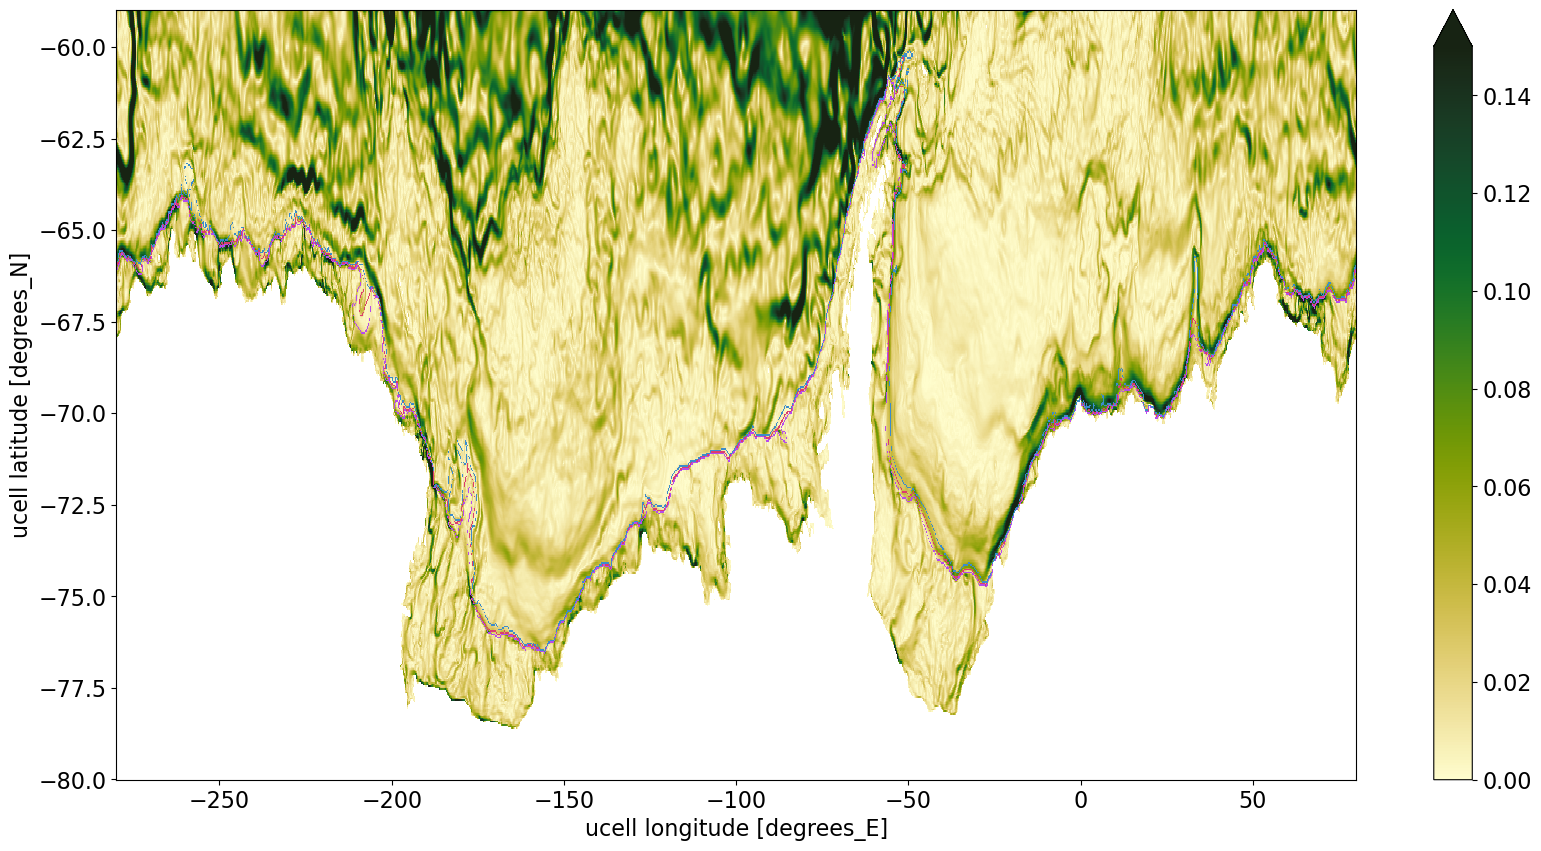

In [25]:
fig = plt.figure(figsize=(20,10))

speed.plot(cmap=cm.cm.speed, vmin=0, vmax=0.15)


plt.pcolormesh(xt_ocean,yt_ocean,np.ma.masked_where(combined_contour_mask_1000<1,combined_contour_mask_1000), cmap=cm.cm.phase)
plt.clim((0,5))


plt.pcolormesh(xt_ocean,yt_ocean,np.ma.masked_where(combined_contour_mask_650<1,combined_contour_mask_650), cmap=cm.cm.phase)
plt.clim((0,5))


plt.pcolormesh(xt_ocean,yt_ocean,np.ma.masked_where(combined_contour_mask_1500<1,combined_contour_mask_1500), cmap=cm.cm.phase)
plt.clim((0,5))


In [47]:
# Function to plot all three contours
def plot_contours():
    cb = speed.plot(cmap=cm.cm.speed, vmin=0, vmax=0.15)
    cb.set_label('Speed (m/s)')
    plt.pcolormesh(xt_ocean,yt_ocean,np.ma.masked_where(combined_contour_mask_1000<1,combined_contour_mask_1000), cmap=cm.cm.phase)
    plt.clim((0,5))
    plt.pcolormesh(xt_ocean,yt_ocean,np.ma.masked_where(combined_contour_mask_650<1,combined_contour_mask_650), cmap=cm.cm.phase)
    plt.clim((0,5))
    plt.pcolormesh(xt_ocean,yt_ocean,np.ma.masked_where(combined_contour_mask_1500<1,combined_contour_mask_1500), cmap=cm.cm.phase)
    plt.clim((0,5))

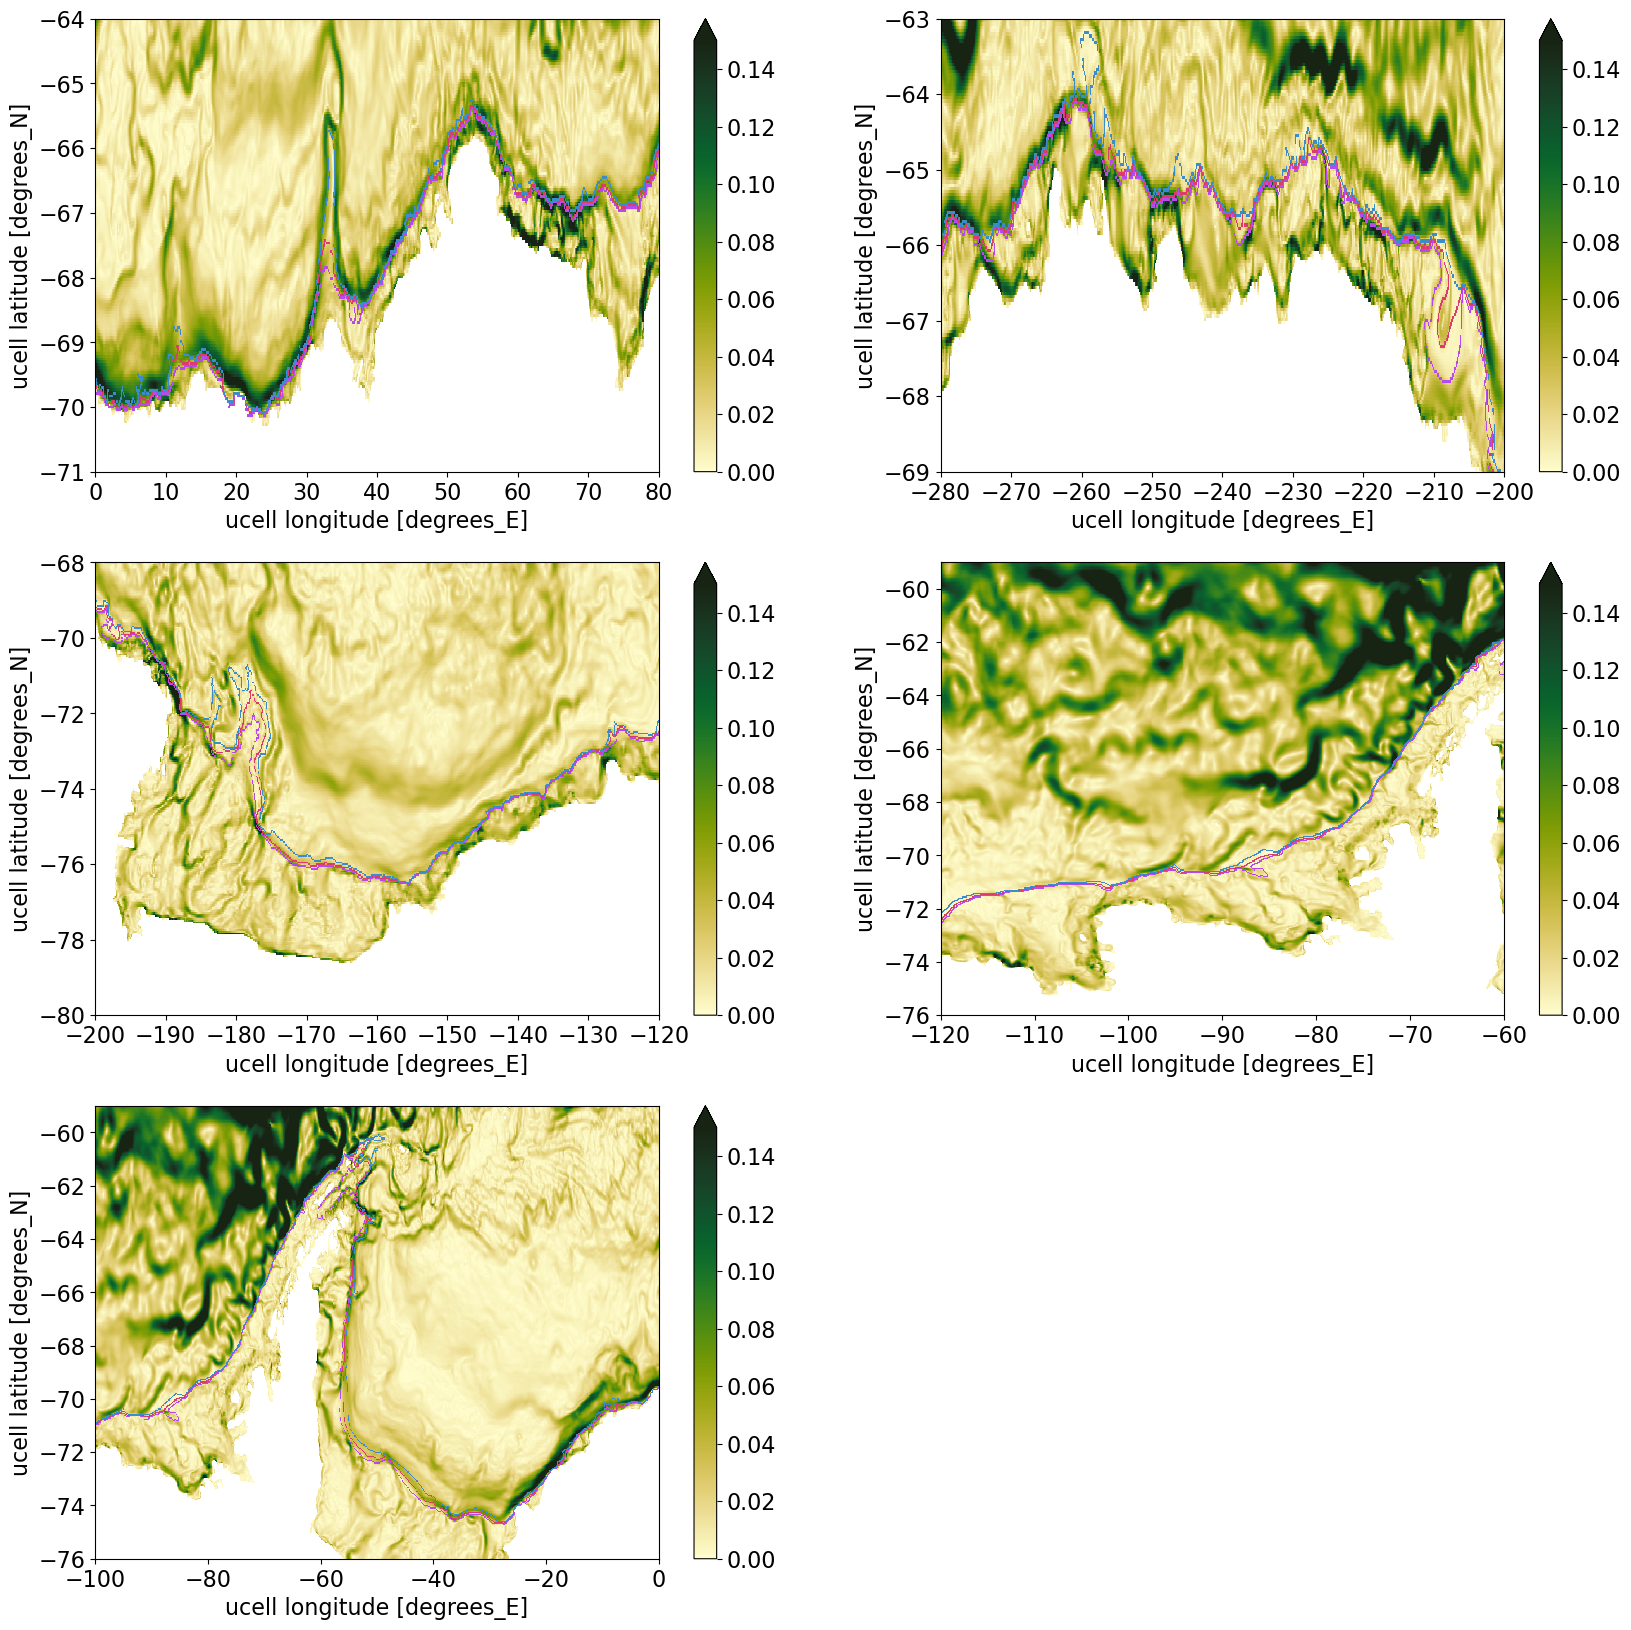

In [48]:
fig = plt.figure(figsize=(20,20))

plt.subplot(3,2,1)
plot_contours()
plt.xlim(0, 80)
plt.ylim(-71, -64)

plt.subplot(3,2,2)
plot_contours()
plt.xlim(-280,-200)
plt.ylim(-69, -63)

plt.subplot(3,2,3)
plot_contours()
plt.xlim(-200,-120)
plt.ylim(-80, -68)

plt.subplot(3,2,4)
plot_contours()
plt.xlim(-120,-60)
plt.ylim(-76, -59)

plt.subplot(3,2,5)
plot_contours()
plt.xlim(-100,0)
plt.ylim(-76, -59);

plt.savefig('/g/data/x77/wgh581/Figures/Figures_ASC_and_HeatTransport/Fig_speed_bathymetry_contours_650m_1000m_1500m.png');

### Check if the isobath has any loops, if so, remove them

1500 m contour

In [ ]:
    # contour_mask[(contour_mask>1656)&(contour_mask<1662)] = 0
    # contour_mask[223,1019] = 1657
    # contour_mask[contour_mask>1661] -= 4
    # contour_mask[(contour_mask>3374)&(contour_mask<3380)] = 0
    # contour_mask[430,2170] = 3375
    # contour_mask[contour_mask>3375] -= 4

In [75]:
contour_mask_numbered_1500 = data_1500['contour_mask_numbered']

contour_mask_numbered_1500[(contour_mask_numbered_1500>8)&(contour_mask_numbered_1500<13)] = 0
contour_mask_numbered_1500[contour_mask_numbered_1500>=13] -= 4

contour_mask_numbered_1500[(contour_mask_numbered_1500>312)&(contour_mask_numbered_1500<315)] = 0
contour_mask_numbered_1500[contour_mask_numbered_1500>=315] -= 2

contour_mask_numbered_1500[(contour_mask_numbered_1500>325)&(contour_mask_numbered_1500<328)] = 0
contour_mask_numbered_1500[contour_mask_numbered_1500>=328] -= 2

contour_mask_numbered_1500[(contour_mask_numbered_1500>404)&(contour_mask_numbered_1500<407)] = 0
contour_mask_numbered_1500[contour_mask_numbered_1500>=407] -= 2

contour_mask_numbered_1500[(contour_mask_numbered_1500>868)&(contour_mask_numbered_1500<871)] = 0
contour_mask_numbered_1500[contour_mask_numbered_1500>=871] -= 2

contour_mask_numbered_1500[(contour_mask_numbered_1500>897)&(contour_mask_numbered_1500<900)] = 0
contour_mask_numbered_1500[contour_mask_numbered_1500>=900] -= 2

contour_mask_numbered_1500[(contour_mask_numbered_1500>1316)&(contour_mask_numbered_1500<1321)] = 0
contour_mask_numbered_1500[contour_mask_numbered_1500>=1321] -= 4

contour_mask_numbered_1500[(contour_mask_numbered_1500>1863)&(contour_mask_numbered_1500<1868)] = 0
contour_mask_numbered_1500[contour_mask_numbered_1500>=1868] -= 4

contour_mask_numbered_1500[(contour_mask_numbered_1500>1996)&(contour_mask_numbered_1500<1999)] = 0
contour_mask_numbered_1500[contour_mask_numbered_1500>=1999] -= 2

contour_mask_numbered_1500[(contour_mask_numbered_1500>2021)&(contour_mask_numbered_1500<2024)] = 0
contour_mask_numbered_1500[contour_mask_numbered_1500>=2024] -= 2

contour_mask_numbered_1500[(contour_mask_numbered_1500>2460)&(contour_mask_numbered_1500<2463)] = 0
contour_mask_numbered_1500[contour_mask_numbered_1500>=2463] -= 2

contour_mask_numbered_1500[(contour_mask_numbered_1500>3580)&(contour_mask_numbered_1500<3583)] = 0
contour_mask_numbered_1500[contour_mask_numbered_1500>=3583] -= 2

contour_mask_numbered_1500[(contour_mask_numbered_1500>3872)&(contour_mask_numbered_1500<3875)] = 0
contour_mask_numbered_1500[contour_mask_numbered_1500>=3875] -= 2

contour_mask_numbered_1500[(contour_mask_numbered_1500>3879)&(contour_mask_numbered_1500<3915)] = 0
contour_mask_numbered_1500[471, 2275] = 3880
contour_mask_numbered_1500[contour_mask_numbered_1500>=3915] -= 34

contour_mask_numbered_1500[(contour_mask_numbered_1500>4000)&(contour_mask_numbered_1500<4003)] = 0
contour_mask_numbered_1500[contour_mask_numbered_1500>=4003] -= 2

contour_mask_numbered_1500[(contour_mask_numbered_1500>4977)&(contour_mask_numbered_1500<4982)] = 0
contour_mask_numbered_1500[contour_mask_numbered_1500>=4982] -= 4

contour_mask_numbered_1500[(contour_mask_numbered_1500>5006)&(contour_mask_numbered_1500<5009)] = 0
contour_mask_numbered_1500[contour_mask_numbered_1500>=5009] -= 2

contour_mask_numbered_1500[(contour_mask_numbered_1500>5254)&(contour_mask_numbered_1500<5260)] = 0
contour_mask_numbered_1500[contour_mask_numbered_1500>=5260] -= 5

contour_mask_numbered_1500[(contour_mask_numbered_1500==5255)] = 0
contour_mask_numbered_1500[contour_mask_numbered_1500>=5256] -= 1

contour_mask_numbered_1500[(contour_mask_numbered_1500>5312)&(contour_mask_numbered_1500<5315)] = 0
contour_mask_numbered_1500[contour_mask_numbered_1500>=5315] -= 2

contour_mask_numbered_1500[(contour_mask_numbered_1500>5334)&(contour_mask_numbered_1500<5340)] = 0
contour_mask_numbered_1500[283, 2910] = 5335
contour_mask_numbered_1500[contour_mask_numbered_1500>=5340] -= 4

contour_mask_numbered_1500[(contour_mask_numbered_1500>5451)&(contour_mask_numbered_1500<5454)] = 0
contour_mask_numbered_1500[contour_mask_numbered_1500>=5453] -= 2

contour_mask_numbered_1500[(contour_mask_numbered_1500>5650)&(contour_mask_numbered_1500<5653)] = 0
contour_mask_numbered_1500[contour_mask_numbered_1500>=5653] -= 2

contour_mask_numbered_1500[(contour_mask_numbered_1500>5709)&(contour_mask_numbered_1500<5712)] = 0
contour_mask_numbered_1500[contour_mask_numbered_1500>=5712] -= 2

contour_mask_numbered_1500[(contour_mask_numbered_1500>5763)&(contour_mask_numbered_1500<5766)] = 0
contour_mask_numbered_1500[contour_mask_numbered_1500>=5766] -= 2

contour_mask_numbered_1500[(contour_mask_numbered_1500>5943)&(contour_mask_numbered_1500<5948)] = 0
contour_mask_numbered_1500[contour_mask_numbered_1500>=5948] -= 4

contour_mask_numbered_1500[(contour_mask_numbered_1500>6050)&(contour_mask_numbered_1500<6053)] = 0
contour_mask_numbered_1500[contour_mask_numbered_1500>=6053] -= 2

contour_mask_numbered_1500[(contour_mask_numbered_1500>6102)&(contour_mask_numbered_1500<6105)] = 0
contour_mask_numbered_1500[contour_mask_numbered_1500>=6105] -= 2

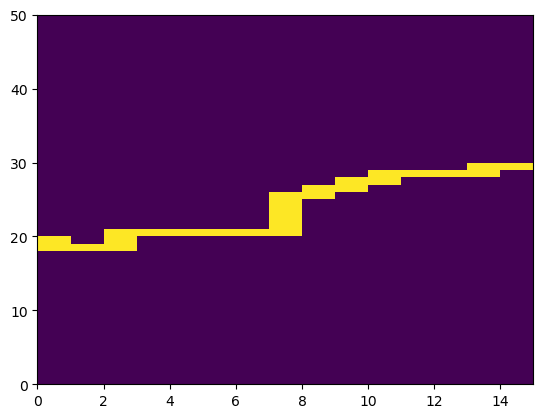

In [90]:
plt.pcolormesh(contour_mask_numbered_1500[330:380, 3585:3640])
plt.clim((300,450))

In [76]:
contour_mask_numbered_1500[368:365, 3330:3338]

array([[   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [6101.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [6102.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [6103.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [6104.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [6105.,    0.,    0.,    0.,    0.,    0., 6113., 6114.],
       [6106., 6107., 6108., 6109., 6110., 6111., 6112.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]],
      dtype=float32)

In [24]:
contour_mask_numbered_1500[283, 2910]

0.0

#### Update masks

In [91]:
exp = '01deg_jra55v13_ryf9091'

lat_range = slice(-90,-59)

yt_ocean = cc.querying.getvar(exp,'yt_ocean',session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
xu_ocean = cc.querying.getvar(exp,'xu_ocean',session,n=1)
xt_ocean = cc.querying.getvar(exp,'xt_ocean',session,n=1)
yu_ocean = cc.querying.getvar(exp,'yu_ocean',session,n=1)

Create mask to separate points above contour from points below contour

In [92]:
# fill in points to north of contour:
contour_masked_above = np.copy(contour_mask_numbered_1500)
contour_masked_above[-1,0] = -100

# from top left:
for ii in range(len(xt_ocean)-1):
    for jj in range(len(yt_ocean))[::-1][:-1]:
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj-1,ii] == 0:
                contour_masked_above[jj-1,ii] = -100
            if contour_masked_above[jj,ii+1] == 0:
                contour_masked_above[jj,ii+1] = -100
            if contour_masked_above[jj-1,ii+1] == 0:
                contour_masked_above[jj-1,ii+1] = -100
# from top right:
for ii in range(len(xt_ocean))[::-1][:-1]:
    for jj in range(len(yt_ocean))[::-1][:-1]:
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj-1,ii] == 0:
                contour_masked_above[jj-1,ii] = -100
            if contour_masked_above[jj,ii-1] == 0:
                contour_masked_above[jj,ii-1] = -100
            if contour_masked_above[jj-1,ii-1] == 0:
                contour_masked_above[jj-1,ii-1] = -100
# from bottom right:
for ii in range(len(xt_ocean))[::-1][:-1]:
    for jj in range(len(yt_ocean)-1):
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj+1,ii] == 0:
                contour_masked_above[jj+1,ii] = -100
            if contour_masked_above[jj,ii-1] == 0:
                contour_masked_above[jj,ii-1] = -100
            if contour_masked_above[jj+1,ii-1] == 0:
                contour_masked_above[jj+1,ii-1] = -100
# from bottom left:
for ii in range(len(xt_ocean)-1):
    for jj in range(len(yt_ocean)-1):
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj+1,ii] == 0:
                contour_masked_above[jj+1,ii] = -100
            if contour_masked_above[jj,ii+1] == 0:
                contour_masked_above[jj,ii+1] = -100
            if contour_masked_above[jj+1,ii+1] == 0:
                contour_masked_above[jj+1,ii+1] = -100


Create masks for x and y transport calculations (i.e. determine if positive u and v will be into or out of contour)

In [93]:
# separate out points on isobath that will correspond to zonal or meridional transport
# across contour (i.e. depending on localshape of contour):

# make masks to multiply x and y transports at correct places:
mask_x_transport = np.zeros_like(contour_mask_numbered_1500)
mask_y_transport = np.zeros_like(contour_mask_numbered_1500)
mask_y_transport_numbered = np.zeros_like(contour_mask_numbered_1500)
mask_x_transport_numbered = np.zeros_like(contour_mask_numbered_1500)
# make halos:
contour_masked_above_halo = np.zeros((contour_masked_above.shape[0],
    contour_masked_above.shape[1]+2))
contour_masked_above_halo[:,0] = contour_masked_above[:,-1]
contour_masked_above_halo[:,1:-1] = contour_masked_above
contour_masked_above_halo[:,-1] = contour_masked_above[:,0]

new_number_count = 1
for mask_loc in range(1,int(np.max(contour_mask_numbered_1500))+1):
    #if mask_loc%100 == 0:
    #    print('mask for x/y transport at point '+str(mask_loc))
    index_i = np.where(contour_mask_numbered_1500==mask_loc)[1]
    index_j = np.where(contour_mask_numbered_1500==mask_loc)[0]
    # if point above is towards Antarctica and point below is away from Antarctica:
    # take transport grid point to north of t grid:
    if (contour_masked_above[index_j+1,index_i]==0) and (contour_masked_above[index_j-1,index_i]!=0):
        mask_y_transport[index_j,index_i] = -1
        # important to do 
        mask_y_transport_numbered[index_j,index_i] = new_number_count
        new_number_count += 1
    # if point below is towards Antarctica and point above is away from Antarctica:
    # take transport grid point to south of t grid:
    elif (contour_masked_above[index_j-1,index_i]==0) and (contour_masked_above[index_j+1,index_i]!=0):
        mask_y_transport[index_j-1,index_i] = 1
        mask_y_transport_numbered[index_j-1,index_i] = new_number_count
        new_number_count += 1
    # if point to right is towards Antarctica and point to left is away from Antarctica:
    # zonal indices increased by 1 due to halos
    # take transport grid point on right of t grid:
    if (contour_masked_above_halo[index_j,index_i+2]==0) and (contour_masked_above_halo[index_j,index_i]!=0):
        mask_x_transport[index_j,index_i] = -1
        mask_x_transport_numbered[index_j,index_i] = new_number_count
        new_number_count += 1
    # if point to left is towards Antarctica and point to right is away from Antarctica:
    # take transport grid point on left of t grid:
    elif (contour_masked_above_halo[index_j,index_i]==0) and (contour_masked_above_halo[index_j,index_i+2]!=0):
        mask_x_transport[index_j,index_i-1] = 1
        mask_x_transport_numbered[index_j,index_i-1] = new_number_count
        new_number_count += 1


Save the data

In [97]:
contour_depth = 1500

import os

In [99]:
save_dir =  '/g/data/x77/wgh581/Post_Process/access-om2'
outfile = os.path.join(save_dir,'Antarctic_slope_contour_1500m_no_loops.npz')

np.savez(outfile,contour_mask_numbered = contour_mask_numbered_1500, 
    contour_masked_above = contour_masked_above, contour_depth = contour_depth,
    xt_ocean = xt_ocean, yt_ocean = yt_ocean,
    mask_y_transport = mask_y_transport, mask_x_transport = mask_x_transport,
    mask_y_transport_numbered = mask_y_transport_numbered, 
    mask_x_transport_numbered = mask_x_transport_numbered)